In [1]:
import os
import numpy as np
import deepdish as dd
import pandas as pd
import nibabel as nb
import Functional_Fusion.dataset as fdata # from functional fusion module
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import cortico_cereb_connectivity.data as cdata
import cortico_cereb_connectivity.cio as cio
import cortico_cereb_connectivity.summarize as cs
import cortico_cereb_connectivity.scripts.script_summarize_weights as cssw
import matplotlib.pyplot as plt
import seaborn as sns
import Functional_Fusion.atlas_map as am
import nitools as nt
from pathlib import Path
import warnings
import SUITPy as suit 
fig_dir =  '/Users/jdiedrichsen/Dropbox (Diedrichsenlab)/Talks/2023/08_Gordon'

/Users/jdiedrichsen/miniconda3/lib/python3.11/site-packages/torch/__init__.py:748: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:448.)
  _C._set_default_tensor_type(t)


# What does the strong orbito-frontal connectivity to the cerebellum mean?  
## Define an ROI on the surface based on the Yeo atlas 

In [30]:
cifti = cssw.assign_parcels_to_cortical_roi()
nb.save(cifti, gl.conn_dir + '/maps/yeo17_Icosahedron1002.plabel.nii')

In [31]:
# visualize the limbic B area on the flatmap  
cifti_img = nb.load(gl.conn_dir + f'/maps/yeo17_Icosahedron1002.plabel.nii')
yeo_parcel = nt.surf_from_cifti(cifti_img) 
is_in_roi = [d==10 for d in yeo_parcel]

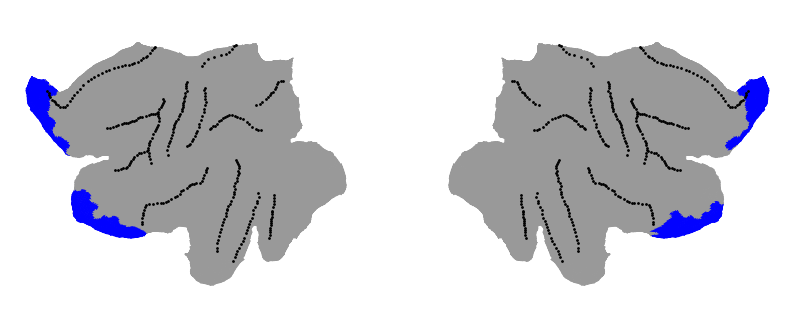

In [32]:
fig, axes = plt.subplots(1, 2,figsize=(10, 4))
cs.plot_cortical_flatmap(data=is_in_roi,axes = axes,overlay_type='label')

## Plot the connectivity probability for the NNLS model 

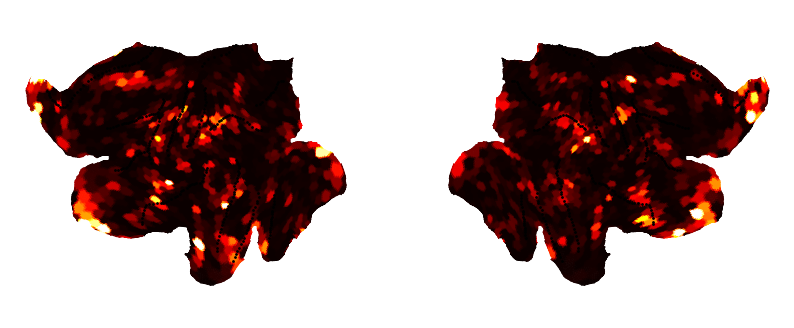

In [5]:
# Plot the connectection probability from the NNLS model
traindata = 'MdWfIbDeHtNiSoScLa'
cortex_roi = "Icosahedron1002"
method = 'NNLS'
stats = 'prob'
cifti_img = nb.load(gl.conn_dir + f'/maps/{traindata}_{cortex_roi}_{method}_{stats}.pscalar.nii')
connect_prob = nt.surf_from_cifti(cifti_img) 
fig, axes = plt.subplots(1, 2,figsize=(10, 4))
cs.plot_cortical_flatmap(data=connect_prob,axes = axes, cscale=[0,0.2],cmap='hot')

## Plot the length of the data vector: 
Given that the standardization is done per subject - and then averaged across subject - the length of the data vector indicates the conisistency of response profiles across subjects. 

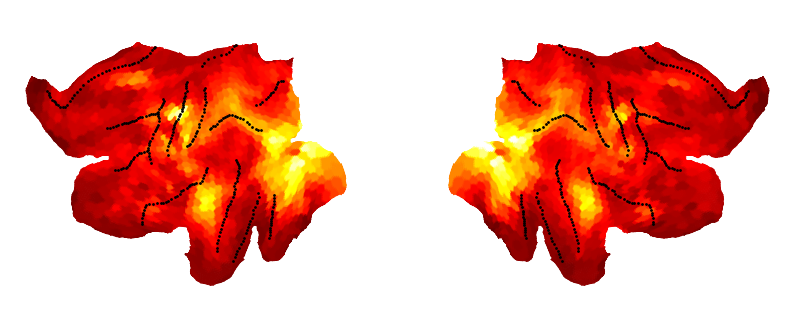

In [34]:
cifti_img = nb.load(gl.conn_dir + f'/maps/{traindata}_data_cortex.pscalar.nii')
avrg_data= nt.surf_from_cifti(cifti_img)
data_length = [np.sum(a**2,axis=0) for a in avrg_data]
fig, axes = plt.subplots(1, 2,figsize=(10, 4))
cs.plot_cortical_flatmap(data=data_length,axes = axes, cscale=[0,900],cmap='hot')

Orbito-frontal cortex has clearly low reliability compared to other regions. 
But then there as other regions with similarily low consistency that do not show the same high weights - so not clear that this is directly related to the problem: 

NOTE: The length of the vectors is stil lthe number of conditions - so longer datasets seem to carry more weight here- Check the global learning code!!

## Plot the average activity in orbito-frontal cortex
What is going on in these areas functional 

In [35]:
T = {} 
T['names']= cifti_img.header.get_axis(0).name
T['dataset'] = [n.split('_')[0] for n in T['names']]
T['cond'] = ['_'.join(n.split('_')[1:-1]) for n in T['names']]
T['half'] = [n.split('_')[-1] for n in T['names']]
T=pd.DataFrame(T)
T

,names,dataset,cond,half
0,MDTB_gng_ngo_half1,MDTB,gng_ngo,half1
1,MDTB_gng_go_half1,MDTB,gng_go,half1
2,MDTB_tom_task_half1,MDTB,tom_task,half1
3,MDTB_actobserv_action_half1,MDTB,actobserv_action,half1
4,MDTB_actobserv_knot_half1,MDTB,actobserv_knot,half1
...,...,...,...,...
1163,Language_dmndgrid_g12s3b2_half2,Language,dmndgrid_g12s3b2,half2
1164,Language_movie_romance_half2,Language,movie_romance,half2
1165,Language_spatialnav_task_half2,Language,spatialnav_task,half2
1166,Language_read_sentence_half2,Language,read_sentence,half2


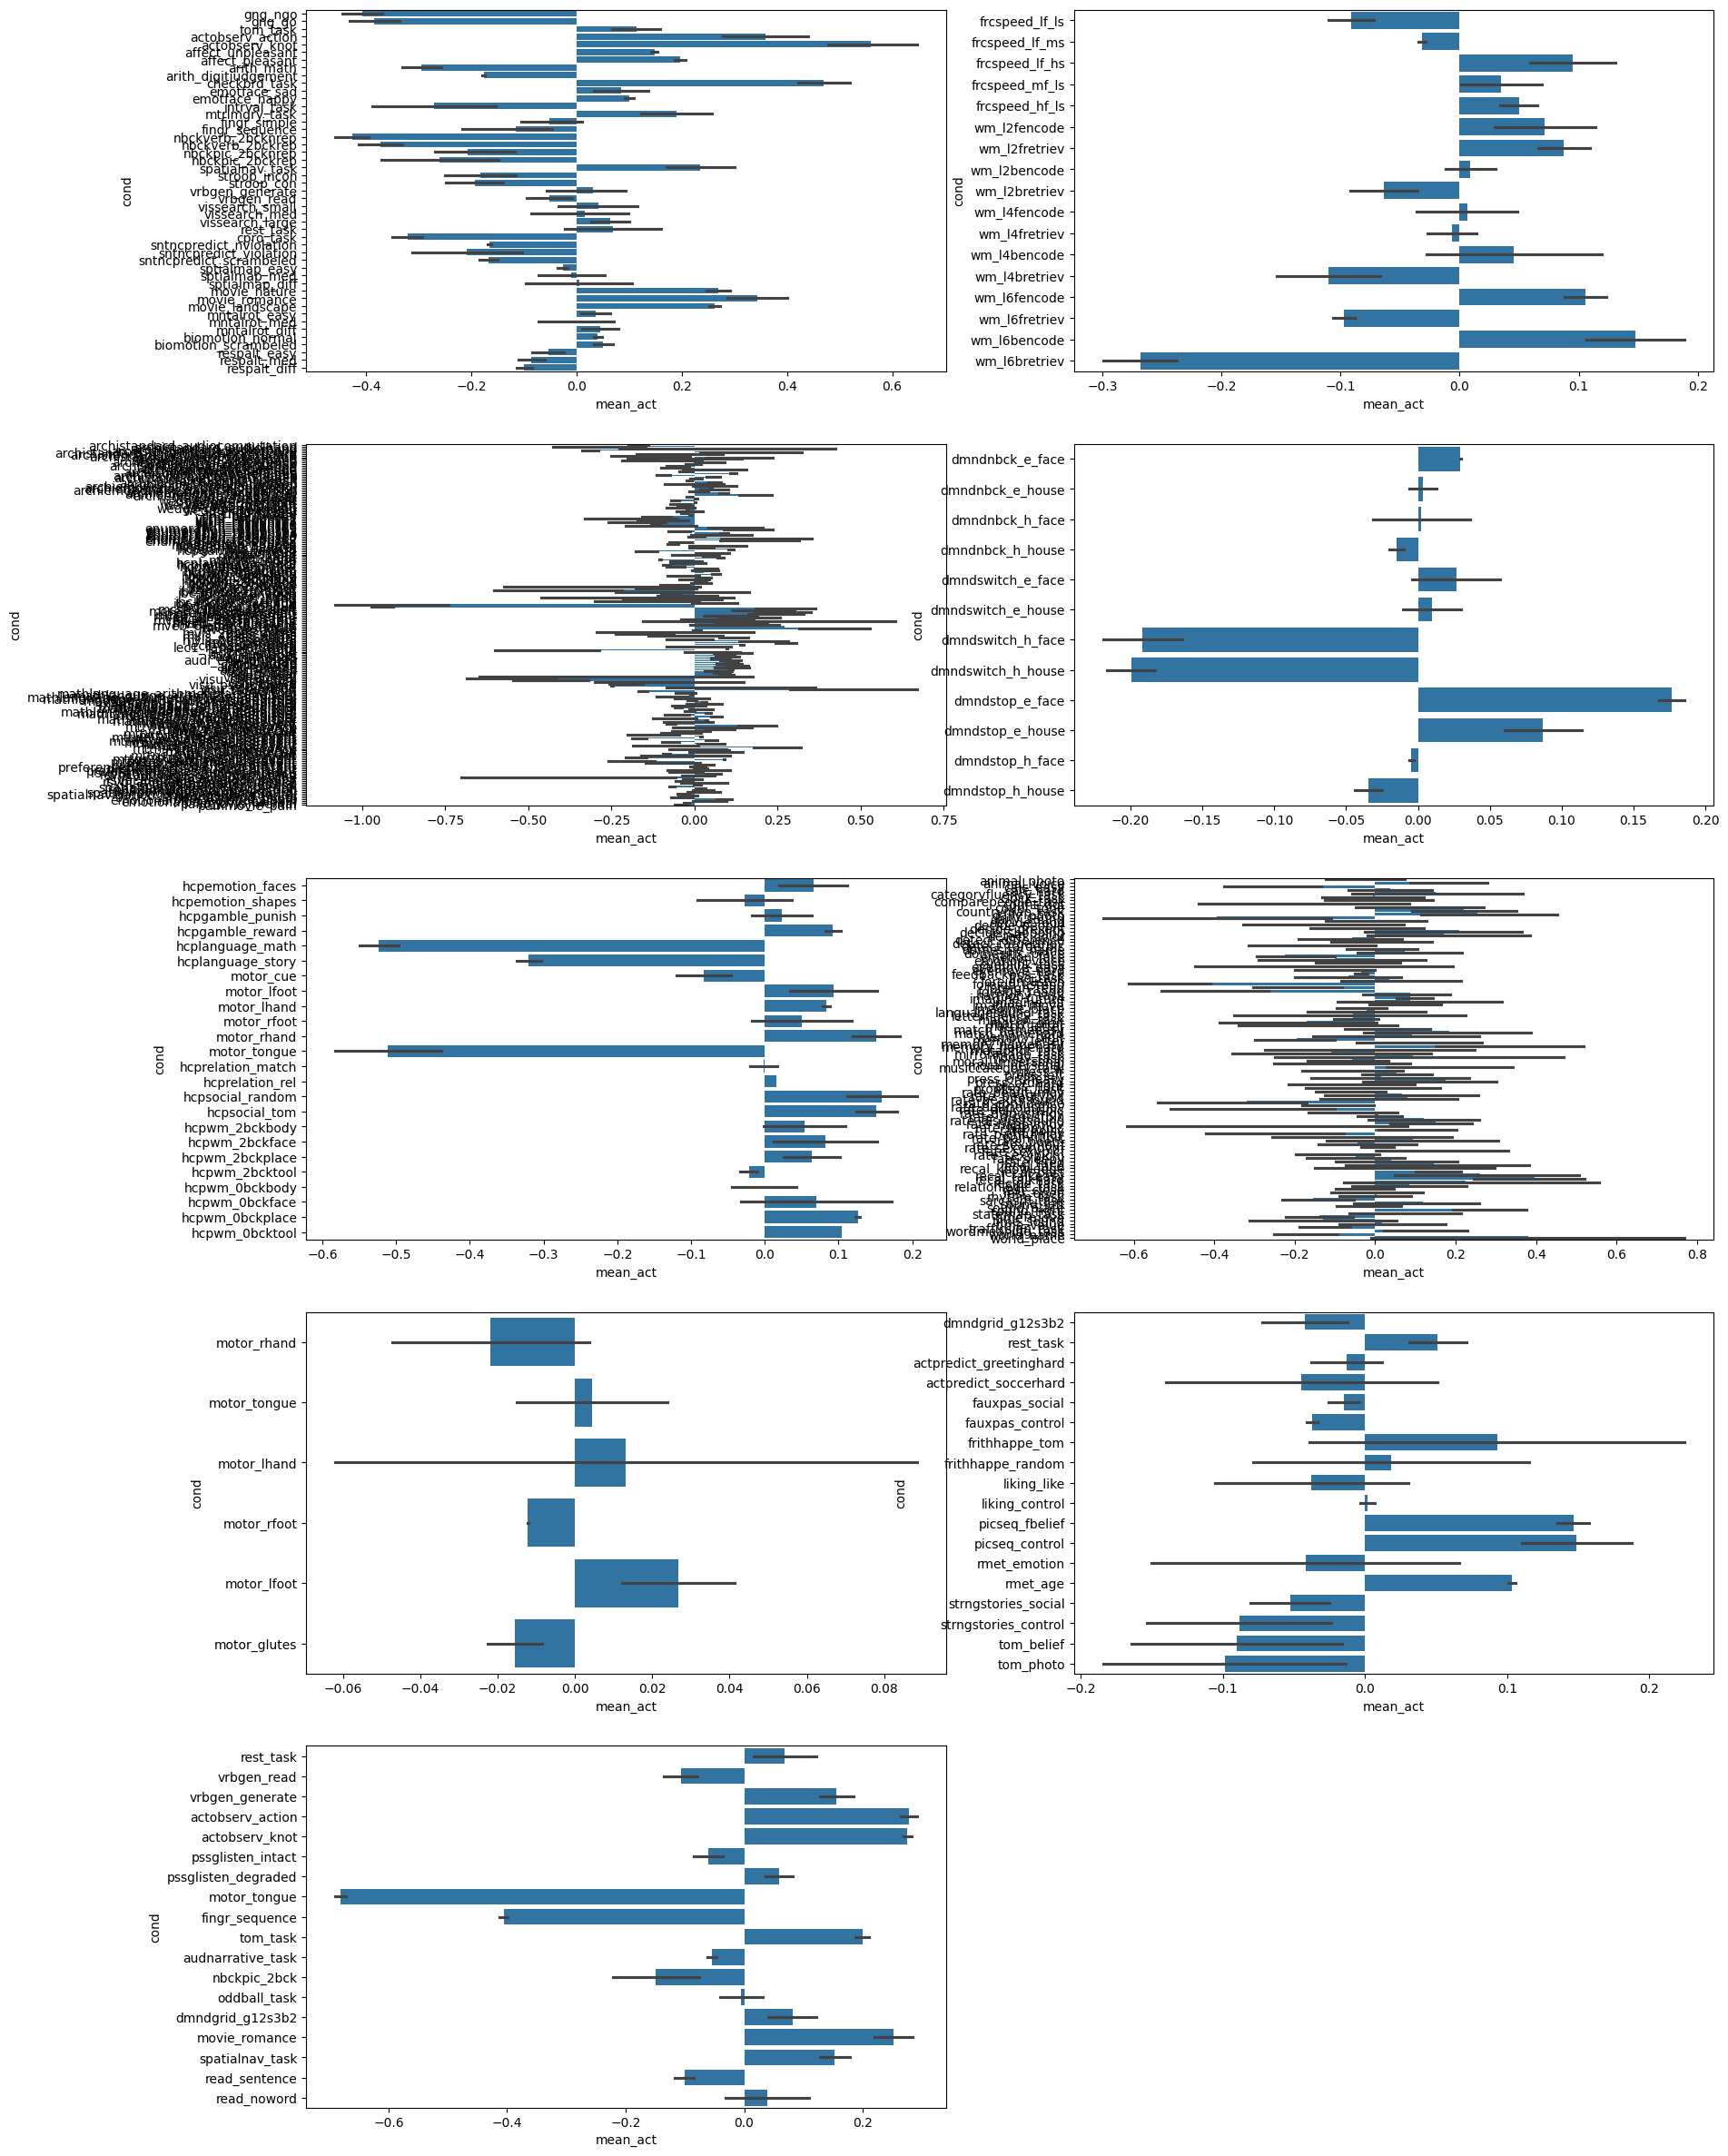

In [36]:
act_img = nb.load(gl.conn_dir + f'/maps/{traindata}_data_cortex.pscalar.nii')
yeo_img = nb.load(gl.conn_dir + f'/maps/yeo17_Icosahedron1002.plabel.nii')
act_data = act_img.get_fdata()
yeo_data = yeo_img.get_fdata().squeeze()

T['mean_act']=act_data[:,yeo_data==10].mean(axis=1) # average activity in all other areas
fig = plt.figure(figsize=(20, 30))
for i, d in enumerate(gl.datasets):
    plt.subplot(5, 2, i+1)
    sns.barplot(x='mean_act',y='cond',data=T[T['dataset']==d])

## Where does the orbito-frontal cortex project to in the cerebellum? 


<Axes: >

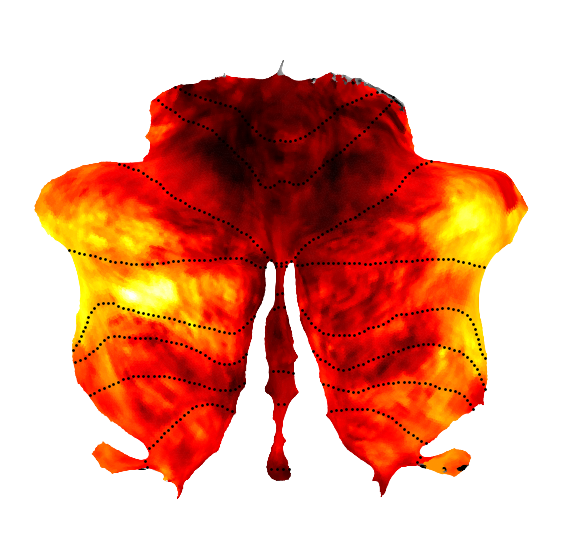

In [53]:
traindata = 'MdWfIbDeHtNiSoScLa'
cortex_roi = "Icosahedron1002"
method = 'NNLS'
model,_ = cs.get_model(traindata,cortex_roi,method,extension='A2_group') 
project = model.coef_[:,yeo_data== 10].mean(axis=1)
atlas,ainf = am.get_atlas('MNISymC3')
nifti_image = atlas.data_to_nifti(project)
data = suit.vol_to_surf(nifti_image,space='MNISymC')
suit.flatmap.plot(data,cmap='hot',cscale=[0,0.008] )